In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
from tqdm import tqdm
from dataclasses import dataclass

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh
from mottmassey import mm_potential

plt.style.use('science')
ratio = 4/3
h = 3

In [2]:
INIT_CONDITIONS = np.array([0, 0.1])


def wave_function(v_r, energy, r_endpts=np.array([1e-4, 2000])):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-8, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol

In [3]:
NUM_STATES = 14
rgf_lo = np.loadtxt(f'rgflow_local_lo_a0_fix_hp_n_{NUM_STATES}.txt')
spectra_lo = np.loadtxt(f'spectra_local_lo_a0_fix_hp_n_{NUM_STATES}.txt')

In [4]:
GUESS = np.array([1.19175560e-01, 1.83340712e-03, -9.86485552e-01, -2.00617369e+01])

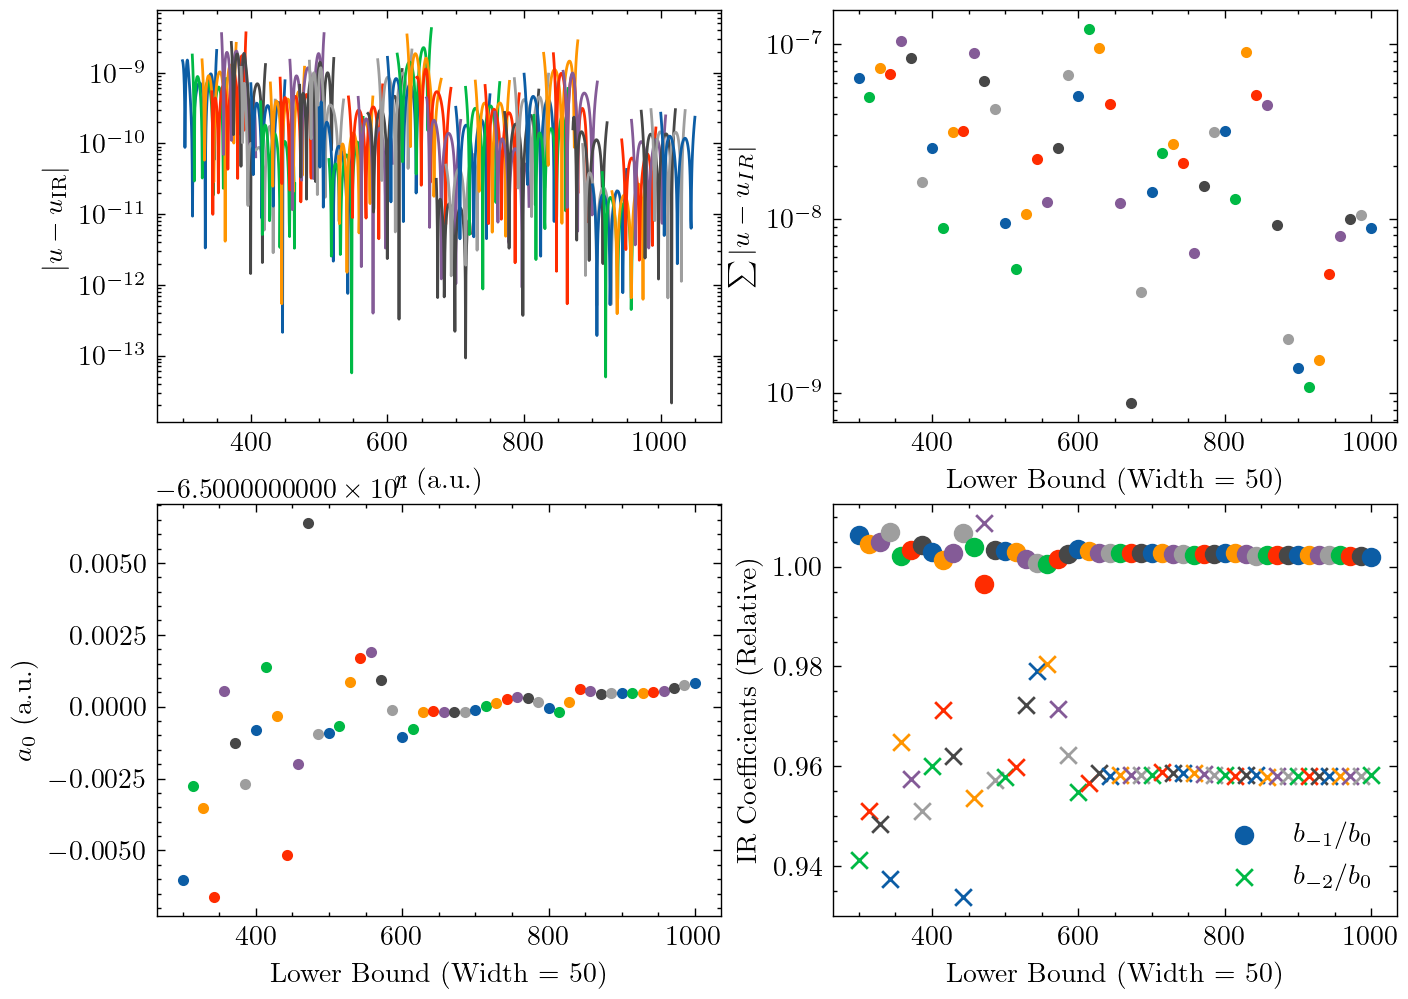

In [11]:
def u0_tail(r, b0, b1):
    return b0 + b1*r


def i4_tail(r, b0, b1, bm1, bm2):
    return b0 + b1*r + bm1/r + bm2/r**2


width = 50

index = 0
Ri, gi = rgf_lo[index]
pot = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)

lower_bounds = np.linspace(300, 1000, 50)

ir1_label = r'$b_{-1}/b_0$'
ir2_label = r'$b_{-2}/b_0$'

fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=200)
fig.patch.set_facecolor('white')

sol = wave_function(mm_potential, 0, r_endpts=[1e-3, 2000])
guess = GUESS.copy()

for lb in lower_bounds:
    
    rs = np.linspace(lb, lb + width, 100)
    u = sol(rs)[0]

    pars, cov = optimize.curve_fit(i4_tail, rs, u, p0=guess)
    guess = pars

    b0, b1, bm1, bm2 = pars
#     print(b0, b1)
    a0 = -b0/b1

    ir1 = bm1/b0
    ir1_pred = BETA4**2/(2*a0)
    
    ir2 = bm2/b0
    ir2_pred = -BETA4**2/6
    
    residuals = np.abs(u - i4_tail(rs, *pars))
    res_sum = np.sum(residuals)
    
    ax[0, 0].plot(rs, residuals)
    ax[0, 0].set_xlabel(rf'$r$ (a.u.)')
    ax[0, 0].set_ylabel(r'$|u - u_{\rm IR}|$')
    ax[0, 0].set_yscale('log')
    
    ax[0, 1].scatter(lb, res_sum, marker='.')
    ax[0, 1].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[0, 1].set_ylabel(r'$\sum|u - u_{IR}|$')
    ax[0, 1].set_yscale('log')
    
    ax[1, 0].scatter(lb, a0, marker='.')
    ax[1, 0].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[1, 0].set_ylabel(r'$a_0$ (a.u.)')
    
    ax[1, 1].scatter(lb, ir1/ir1_pred, marker='o', label=ir1_label)
    ax[1, 1].scatter(lb, ir2/ir2_pred, marker='x', label=ir2_label)
    ax[1, 1].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[1, 1].set_ylabel(r'IR Coefficients (Relative)')
    
    ir1_label = None
    ir2_label = None

ax[1, 1].legend();

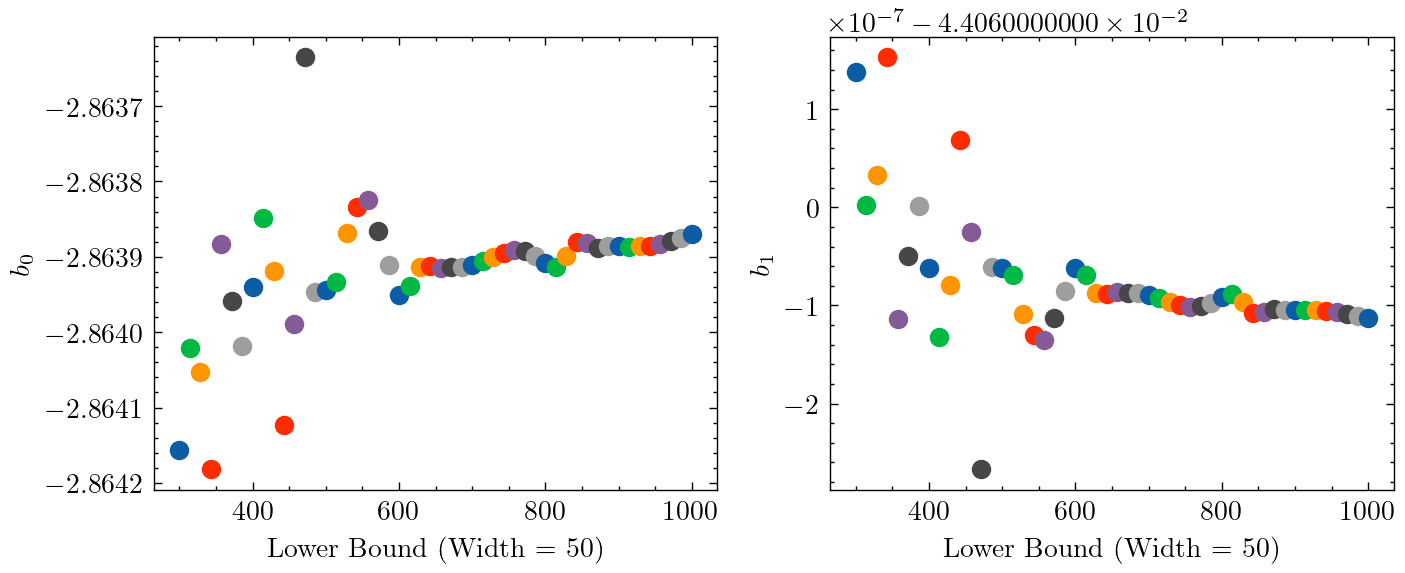

In [14]:
def u0_tail(r, b0, b1):
    return b0 + b1*r


def i4_tail(r, b0, b1, bm1, bm2):
    return b0 + b1*r + bm1/r + bm2/r**2


width = 50

index = 0
Ri, gi = rgf_lo[index]
pot = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)

lower_bounds = np.linspace(300, 1000, 50)

ir1_label = r'$b_{-1}/b_0$'
ir2_label = r'$b_{-2}/b_0$'

fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

sol = wave_function(mm_potential, 0, r_endpts=[1e-3, 2000])
guess = GUESS.copy()

for lb in lower_bounds:
    
    rs = np.linspace(lb, lb + width, 100)
    u = sol(rs)[0]

    pars, cov = optimize.curve_fit(i4_tail, rs, u, p0=guess)
    guess = pars

    b0, b1, bm1, bm2 = pars
#     print(b0, b1)
    a0 = -b0/b1

    ir1 = bm1/b0
    ir1_pred = BETA4**2/(2*a0)
    
    ir2 = bm2/b0
    ir2_pred = -BETA4**2/6
    
    residuals = np.abs(u - i4_tail(rs, *pars))
    res_sum = np.sum(residuals)
    
    ax[0].scatter(lb, b0)
    ax[0].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[0].set_ylabel(r'$b_0$')
    
    ax[1].scatter(lb, b1)
    ax[1].set_xlabel(rf'Lower Bound (Width = {width})')
    ax[1].set_ylabel(r'$b_1$')

In [6]:
A0_MM = -65
rs = np.linspace(700, 725, 100)

In [7]:
@dataclass
class Coefficients:
    '''
    Stores coefficients to IR-corrected, zero-energy, 1/r^4 wave function:
    u_{IR}(r) = b_0 + b_1 r + b_{-1} / r + b_{-2} / r^2
    '''
    b_0 : float
    b_1 : float
    b_m1 : float
    b_m2 : float
        
    def a_0(self):
        return -self.b_0 / self.b_1
    
    
    def b_m1_scaled(self):
        return self.b_m1 / self.b_0

    
    def b_m2_scaled(self):
        return self.b_m2 / self.b_0
    
    
    def b_m1_predicted(self):
        return BETA4**2/(2*self.a_0())
    
    
    def b_m2_predicted(self):
        return -BETA4**2/6
    

In [8]:
def extract_coefficients(pot, p0=GUESS.copy()):
    sol = wave_function(pot, 0, r_endpts=[1e-6, 1000])
    u = sol(rs)[0]
    pars, cov = optimize.curve_fit(i4_tail, rs, u, p0=p0)
    return pars


def extract_a0(pot, p0=GUESS.copy()):
    b0, b1, _, _ = extract_coefficients(pot, p0=p0)
    return -b0/b1


def diff(g, R, p0):
    pot = lambda r: potential(r, R) + g*local_LO_counterterm(r, R)
    a0 = extract_a0(pot, p0=p0)
    return (A0_MM - a0)/A0_MM

In [9]:
from scipy.interpolate import interp1d

In [10]:
results = []
coeffs = []
p0 = GUESS.copy()

for i in tqdm(range(rgf_lo.shape[0])):
    Ri, guess = rgf_lo[i]
    
    if i > 10:
        x = np.array(results)[-5:, 0]
        y = np.array(results)[-5:, 1]
        f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
        guess = f(Ri)
    
    c0 = optimize.fsolve(diff, guess, args=(Ri, p0))[0]
    
    pot = lambda r: potential(r, Ri) + c0*local_LO_counterterm(r, Ri)
    pars = extract_coefficients(pot, p0)
    p0 = pars
    
    coeffs.append(Coefficients(*pars))
    results.append([Ri, c0])

 17%|███████▍                                   | 17/98 [00:03<00:22,  3.66it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 56%|████████████████████████▏                  | 55/98 [00:14<00:10,  4.07it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 90%|██████████████████████████████████████▌    | 88/98 [00:29<00:06,  1.50it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:792: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
 99%|████████████████████████

ValueError: array must not contain infs or NaNs

In [11]:
results = np.array(results)

(-10.0, 1000.0)

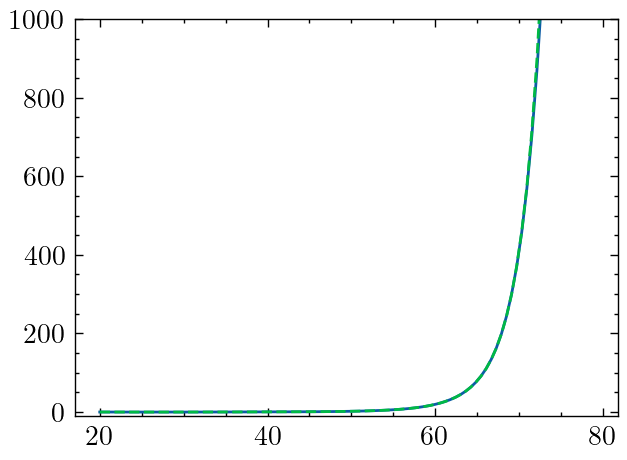

In [12]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/results[:, 0], results[:, 1])
ax.plot(BETA4/rgf_lo[:, 0], rgf_lo[:, 1], linestyle='--')

ax.set_ylim([-10, 1000])
# ax.set_yscale('log');

In [13]:
a0s = np.array([c.a_0() for c in coeffs])

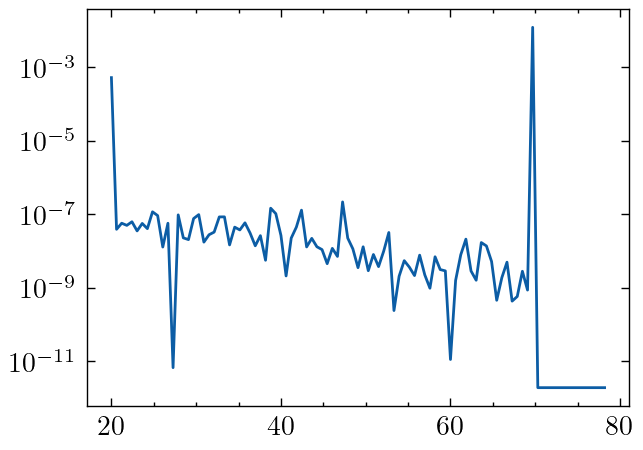

In [14]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/results[:, 0], np.abs((A0_MM - a0s)/A0_MM))
ax.set_yscale('log');
# ax.axhline(A0_MM, color='C1', linestyle='--');

In [15]:
ii = np.where(np.abs((A0_MM - a0s)/A0_MM) < 1e-6)[0]

In [16]:
ii

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

In [19]:
np.savetxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt', results[ii, :])